# KBMod Analysis Demo

To run an example of kbmod from start to finish you can use the following steps:

1) Setup `kbmod` with the `setup.bash` file in the main directory of the repo by: `source setup.bash`

2) Run `example_search.py` with the following settings:

  * **image_dir**: The directory with the images from a single field
    
  * **results_dir**: The directory where you want to save the results
    
  * **results_suffix**: Suffix to add when saving results files. Setting this as `test` then files will be saved as "..._test.txt". Five results files would be saved:
      * `lc_test.txt`: File with the light curves from results after going through Kalman Filter.
      * `results_test.txt`: File with the x,y pixel locations, velocity, flux, likelihood, and number of unmasked observations of each result.
      * `ps_test.txt`: File with the summed postage stamp for each result.
      * `times_test.txt`: File with the MJD of each observation in the saved lightcurve.
      * `filtered_likes_test.txt`: The recalculated likelihood values for each results after removing observations with the Kalman Filter.
  * **time_file**: Location of a file with each row containing (visit_num, visit_mjd) for observations in dataset.
    
3) Command will be like the following:

```
python3 example_search.py --image_dir image_dir --results_dir results_dir --results_suffix test --time_file image_times.dat
```

4) Once you have the results you can use the steps in this notebook to create plots with postage stamps and lightcurves side-by-side for a final look by eye.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from create_stamps import create_stamps
%matplotlib inline

In [4]:
import torch
from classify import Net
import tensorflow as tf
use_pytorch = False
use_keras = True
if use_pytorch:
    model = torch.load('kbmod_cnn_background_1000e.pt')
    model.cpu()
    model.float()
    model.eval()
if use_keras:
    keras_model = tf.keras.models.load_model('./resnet_model_v7.h5')
    
def m_input(arr):
    dat = torch.tensor([[arr]])
    dat = dat.to('cpu', torch.float)
    return dat
def predict(img):
    val = model(m_input(img)).argmax(dim=1, keepdim=True)
    return val.item()
def prob_predict(img,cutoff=0.5):
    probs = np.concatenate(np.e**model(m_input(img)).detach().numpy())
    if probs[1]>=cutoff:
        return(1)
    else:
        return(0)
def mispredictions(imgs, correct_answer):
    wrong = []
    for idx, img in enumerate(imgs):
        if (not predict(img) == correct_answer):
            wrong.append(idx)
    return wrong

def no_filter(imgs):
    good_idx = np.linspace(0,len(imgs)-1,len(imgs))
    return(good_idx.astype(int))

def cnn_filter(imgs,model_type='keras', cutoff=0.5):
    good_idx = np.linspace(0,len(imgs)-1,len(imgs))
    #stamps = np.array([np.concatenate(stamp) for stamp in stamps])
    true_false = []
    if model_type=='keras':
        keras_stamps = []
        sigmaG_coeff =  0.7413
        for img in imgs:
            per25,per50,per75 = np.percentile(img,[25,50,75])
            sigmaG = sigmaG_coeff * (per75 - per25)
            img[img<(per50-2*sigmaG)] = per50-2*sigmaG
            img -= np.min(img)
            img /= np.sum(img)
            img = img.reshape(21,21)
            keras_stamps.append(img)
        keras_stamps = np.reshape(keras_stamps,[-1,21,21,1])
        cnn_results = keras_model.predict(keras_stamps)
        good_idx = good_idx[cnn_results[:,1]>cutoff]
    elif model_type=='pytorch':
        for img in imgs:
            img -= np.min(img)
            img /= np.sum(img)
            img = img.reshape(21,21)
            true_false.append(prob_predict(img,cutoff))
        true_false = np.array(true_false)
        good_idx = good_idx[np.where(true_false==1)]
    #print(good_idx.astype(int))
    return(good_idx.astype(int))
        

def loadStamps(results_dir,time_list,suffix):

    image_list = sorted(os.listdir(im_dir))
    image_list = [os.path.join(im_dir, im_name) for im_name in image_list]

    stamper = create_stamps()
    lc_filename = os.path.join(results_dir, 'lc_%s.txt' % suffix)
    psi_filename = os.path.join(results_dir, 'psi_{}.txt'.format(suffix))
    phi_filename = os.path.join(results_dir, 'phi_{}.txt'.format(suffix))
    lc_index_filename = os.path.join(results_dir, 'lc_index_%s.txt' % suffix)
    lc_list,lc_index = stamper.load_lightcurves(lc_filename,lc_index_filename)
    psi,phi,lc_index = stamper.load_psi_phi(psi_filename, phi_filename, lc_index_filename)
    stamp_filename = os.path.join(results_dir, 'ps_%s.txt' % suffix)
    result_filename = os.path.join(results_dir, 'results_%s.txt' % suffix)

    result_exists = os.stat(result_filename).st_size

    if result_exists:
        stamps = stamper.load_stamps(stamp_filename)
        all_stamps=np.load(os.path.join(results_dir, 'all_ps_%s.npy' % suffix))
        results = stamper.load_results(result_filename)
        keep_idx = []
        for lc_num, lc in list(enumerate(lc_list)):
            if len(lc) > 5:
                keep_idx.append(lc_num)
        return(keep_idx,results,stamper,stamps,all_stamps,lc_list,psi,phi,lc_index)
    else:
        warnings.warn('No results found. Returning 0')
        return(0,0,0,0,0,0,0)
    
def neighbor_filter(stamps, limit):
    good_idx = []
    for i,stamp in enumerate(stamps):
        stamp = stamp.reshape(21,21)
        bright_px = np.where(stamp==np.max(stamp))
        x_idx = bright_px[0][0]
        y_idx = bright_px[1][0]
        neighbors = stamp[x_idx-1:x_idx+2,y_idx-1:y_idx+2]
        mean_neighbor = np.mean(neighbors[neighbors!=np.max(stamp)])
        ratio = np.max(stamp)/mean_neighbor
        if ratio < limit:
            good_idx.append(i)
    return(good_idx)

def rfc_filter(stamps):
    good_idx = np.linspace(0,len(stamps)-1,len(stamps))
    #stamps = np.array([np.concatenate(stamp) for stamp in stamps])
    true_false = ml_model.predict(stamps)
    good_idx = good_idx[np.where(true_false==1)]
    return(good_idx.astype(int))

In [5]:
import pickle
with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/known_objects/allObjectData_2.pkl', 'rb') as f:
        allObjectData = pickle.load(f)
known_data = np.loadtxt('/epyc/projects2/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/known_object_list.txt')
known_format = "pg{:03d}_ccd{:02d}"

with open('/astro/store/epyc/users/smotherh/kbmod_epyc/notebooks/rfc_kbmod.model', 'rb') as pickle_file:
    ml_model = pickle.load(pickle_file)

/epyc/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [49]:
res_per_cutoff = []
comp_per_cutoff = []

/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Found 37 objects
Missed 12 objects
Exceptions 0


AttributeError: 'numpy.ndarray' object has no attribute 'append'

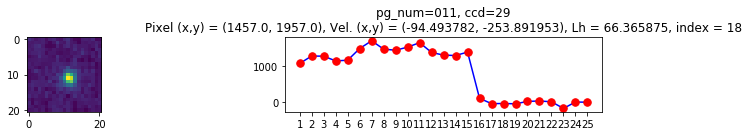

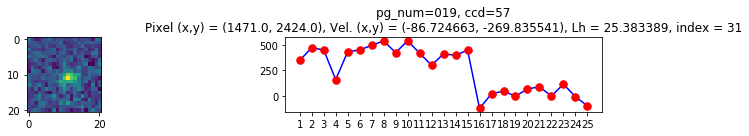

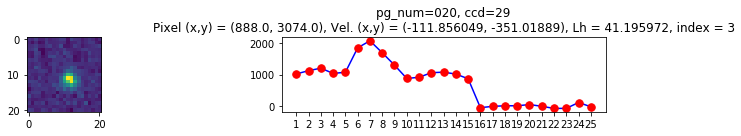

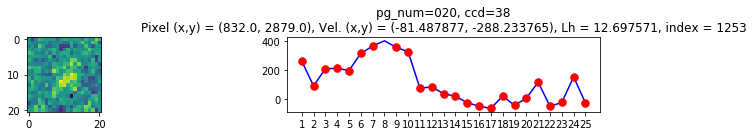

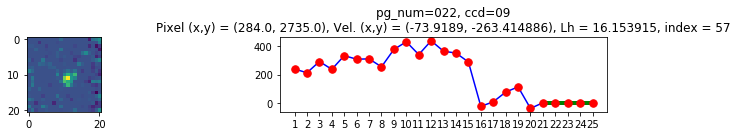

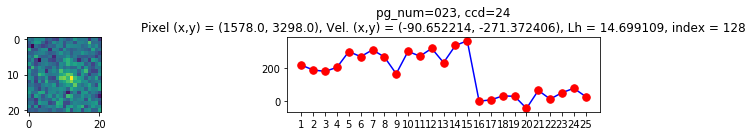

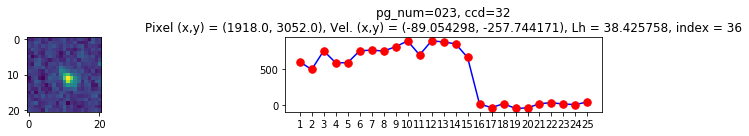

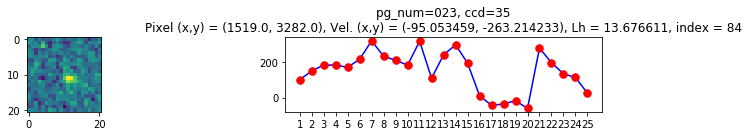

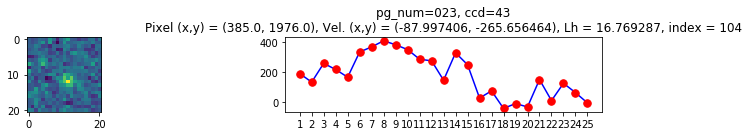

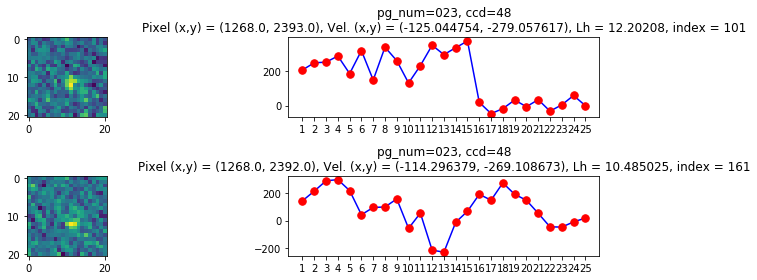

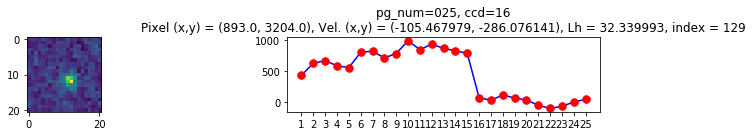

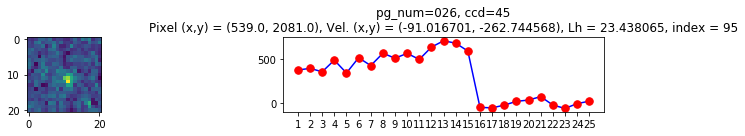

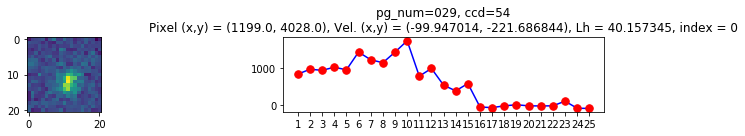

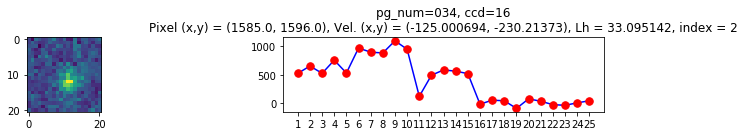

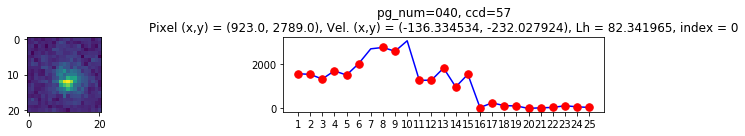

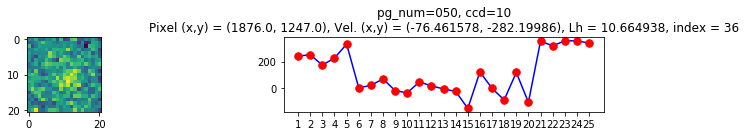

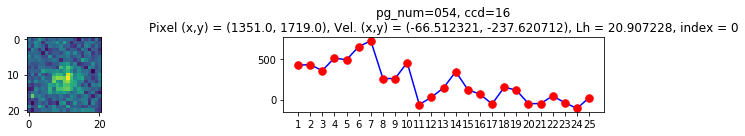

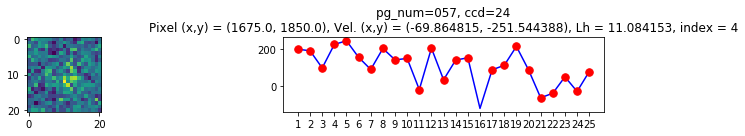

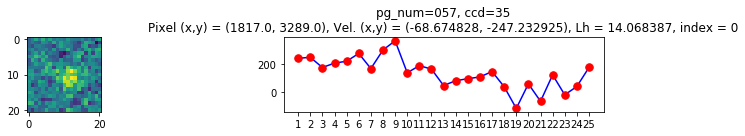

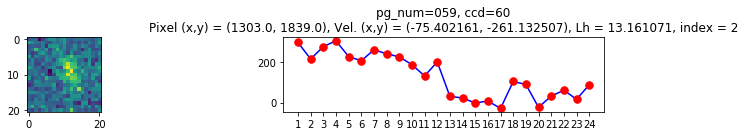

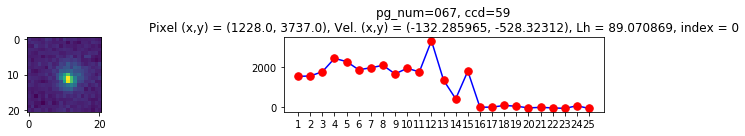

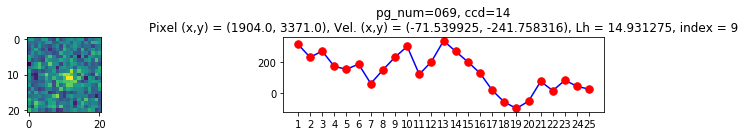

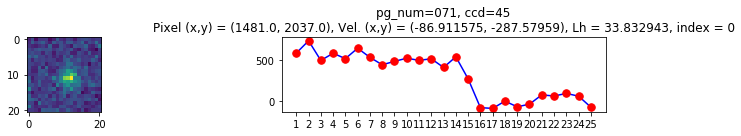

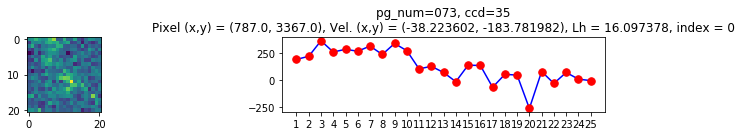

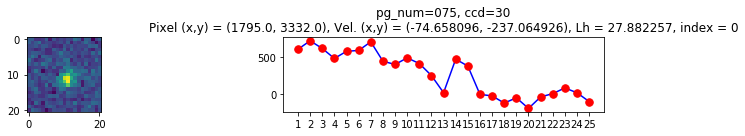

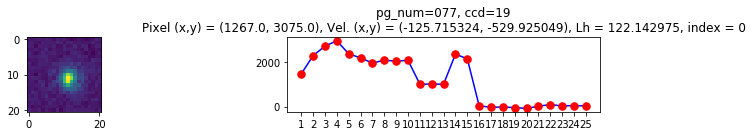

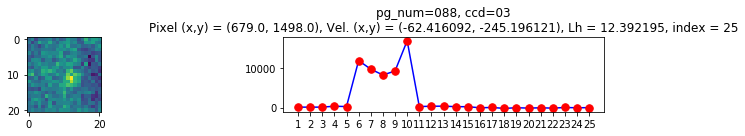

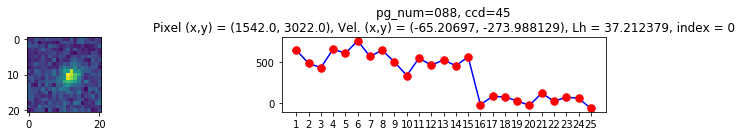

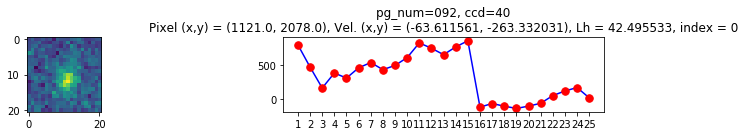

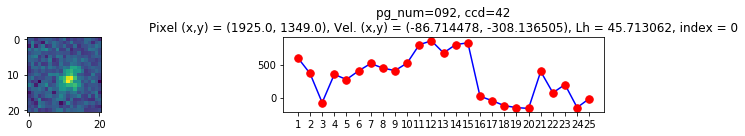

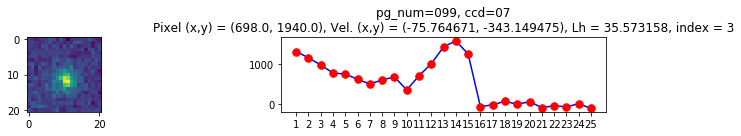

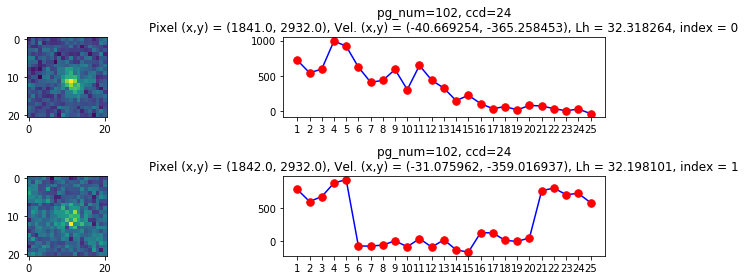

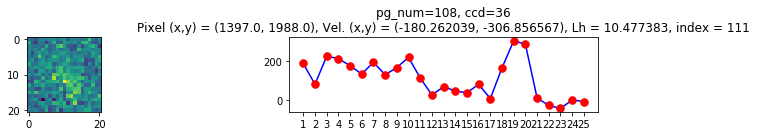

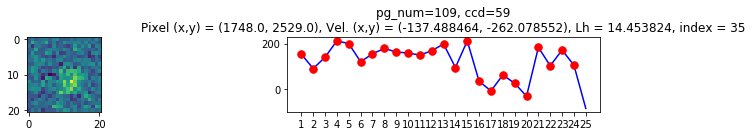

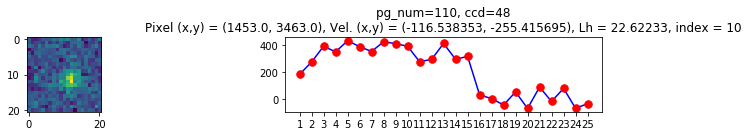

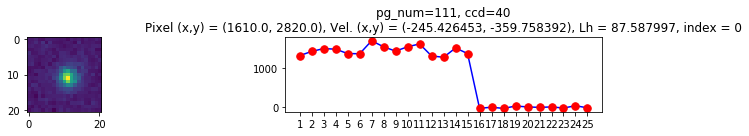

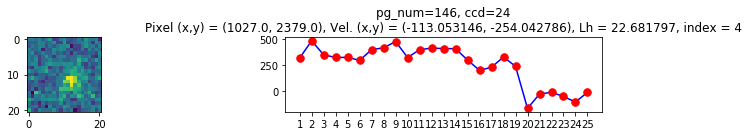

In [158]:
# Directory where output from kbmod search are located
all_good_idx = []
num_found_objects=0
found_objects={}
missed_objects={}
found_vmag = []
v_mag = []
num_results_neighbor = []
res_per_ccd = []
all_coadd_stamps = []
good_coadd_stamps = []
all_stamp_probs=[]
found_stamps=[]
found_results = {}
num_except = 0
num_stamps = 0
for pgccd in known_data:
    pg_num = int(pgccd[0])
    ccd_num = int(pgccd[1])
    
    object_key = known_format.format(pg_num, ccd_num)
    xy_array = allObjectData[object_key][5]
    v_array = allObjectData[object_key][2]
    v_mag.append(allObjectData[object_key][1])
    results_dir = '/epyc/projects2/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
    im_dir = '/epyc/projects2/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{0:03}/warps/{1:02d}/'.format(pg_num,ccd_num)
    suffix = 'more_objs'

    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()
    try:
        times_list = stamper.load_times(times_filename)
        keep_idx,results,stamper,stamps,all_stamps,lc_list,psi_list,phi_list,lc_index = loadStamps(results_dir,times_list,suffix)
    except:
        num_except+=1
        continue
        #good_idx = rfc_filter(stamps)
    num_stamps += len(stamps)
    good_idx = no_filter(stamps)
    #good_idx = cnn_filter(np.copy(stamps),cutoff=0.001)
    res_per_ccd.append(len(good_idx))
    if len(good_idx)<1:
        missed_objects[object_key] = allObjectData[object_key]
        print('Failed CCN Filtering. Continuing...')
        continue
    for idx in good_idx:
        good_coadd_stamps.append(stamps[idx])
    #num_results_neighbor.append(len(cnn_good_idx))
    if np.count_nonzero(results) != 0:
        if len(lc_list)==1:
            results=[results]
        #stamps_fig, object_found, found_idx = stamper.target_stamps(
        #    results, lc_list, lc_index, stamps, 0.03, xy_array, target_vel=v_array,
        #    vel_tol=30, atol=5, title_info='pg_num={:03d}, ccd={:02d}'.format(*pgccd.astype(int)))
        #all_coadd_stamps.append([element for i, element in enumerate(stamps) if i not in found_idx])
        stamps_fig, object_found, found_idx = stamper.target_stamps(
            results[good_idx], np.array(lc_list)[good_idx], np.array(lc_index)[good_idx], np.copy(stamps[good_idx]), 0.03, xy_array, target_vel=v_array,
            vel_tol=30, atol=5, title_info='pg_num={:03d}, ccd={:02d}'.format(*pgccd.astype(int)))
        if object_found:
            num_found_objects+=1
            found_stamps.append(stamps[good_idx][found_idx])
            found_vmag.append(allObjectData[object_key][1])
            found_objects[object_key] = allObjectData[object_key]
            found_results[object_key] = results[good_idx][found_idx]
        else:
            missed_objects[object_key] = allObjectData[object_key]
    else:
        missed_objects[object_key] = allObjectData[object_key]
print('Found {} objects'.format(len(found_objects)))
print('Missed {} objects'.format(len(missed_objects)))
print('Exceptions {}'.format(num_except))
        #stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.03)
res_per_cutoff.append(res_per_ccd)
comp_per_cutoff.append(len(found_vmag)/len(v_mag))

In [161]:
sum_array

[851, 1389, 3732, 8800, 52501, 16786]

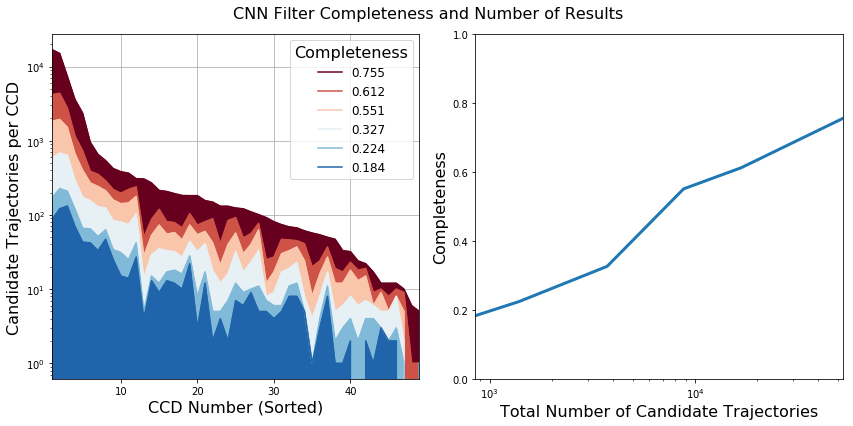

In [14]:
#np.save('Results_Per_Cutoff_Stats.npy',[comp_per_cutoff,res_per_cutoff])
comp_per_cutoff,res_per_cutoff = np.load('Results_Per_Cutoff_Stats.npy',allow_pickle=True)
idx = np.argsort(comp_per_cutoff)
jdx = np.argsort(res_per_cutoff[idx[-1]])[::-1]
col = plt.cm.RdBu(np.linspace(0,.9,len(comp_per_cutoff)))
legend = []
x = np.linspace(1,len(res_per_cutoff[0]),len(res_per_cutoff[0]))
#for i,res in enumerate(res_per_cutoff):
#    plt.hist(res,range=(0,len(res_per_cutoff[0])),color='k',alpha=.1+i/len(res_per_cutoff))
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=[12,6])
for i,res in enumerate(np.array(res_per_cutoff)[idx][::-1]):
    ax[0].fill_between(x,np.array(res)[jdx],0,color=col[i])
    ax[0].semilogy(x,np.array(res)[jdx],color=col[i])
    legend.append("{:.3f}".format(np.array(comp_per_cutoff)[idx][::-1][i]))
ax[0].set_axisbelow(True)
ax[0].grid()
ax[0].legend(legend,title="Completeness",fontsize=12,title_fontsize=16)
ax[0].set_xlim([1,49])
ax[0].set_xlabel('CCD Number (Sorted)',fontsize=16)
ax[0].set_ylabel('Candidate Trajectories per CCD',fontsize=16)
sum_array = []
for res in res_per_cutoff:
    sum_array.append(np.sum(res))
ax[1].semilogx(np.array(sum_array)[idx],comp_per_cutoff[idx],lw=3)
ax[1].set_ylim([0,1])
ax[1].set_xlim([np.min(sum_array),np.max(sum_array)])
ax[1].set_xlabel('Total Number of Candidate Trajectories',fontsize=16)
ax[1].set_ylabel('Completeness',fontsize=16)
_ = fig.suptitle('CNN Filter Completeness and Number of Results',fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('CNN_Filt_Stats.png')
#plt.figure()
#_=plt.semilogx(res_per_cutoff, comp_per_cutoff)

In [47]:
print(len(good_coadd_stamps))
print(num_stamps)
print(len(good_coadd_stamps)/num_stamps)

51223
52501
0.9756576065217806


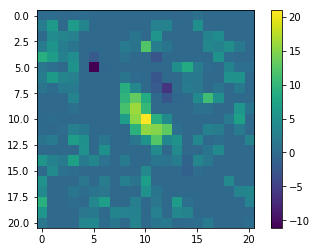

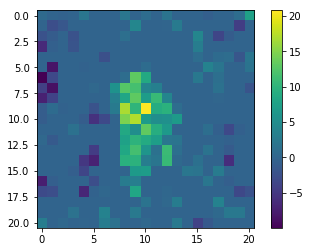

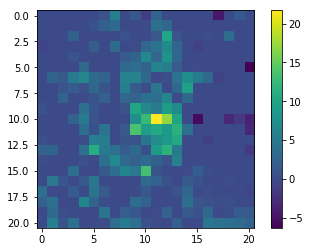

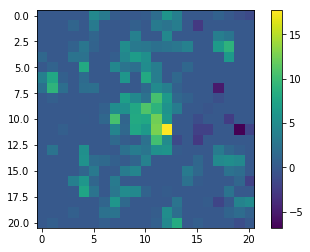

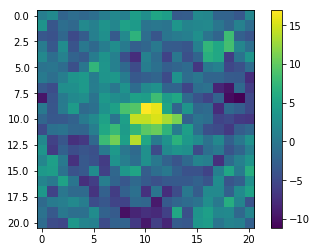

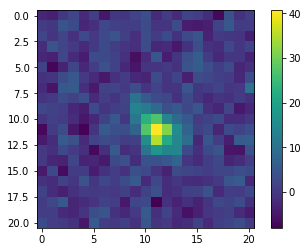

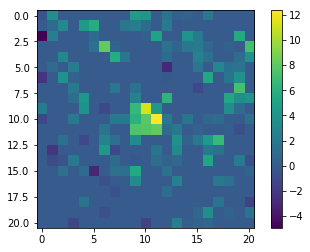

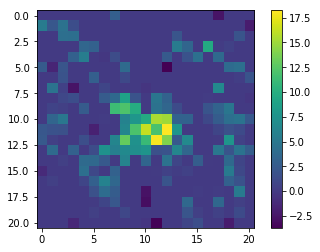

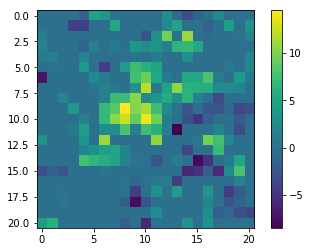

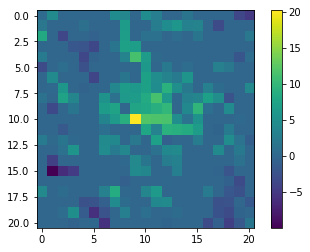

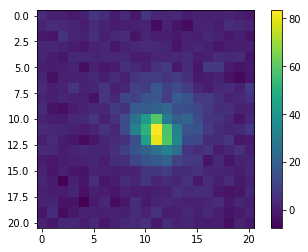

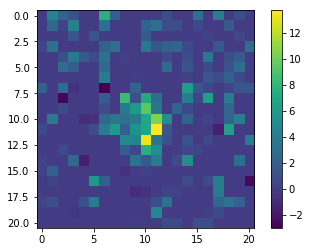

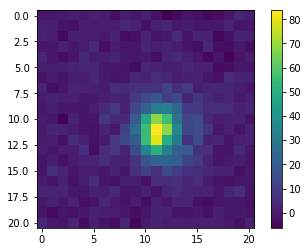

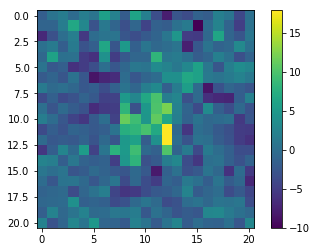

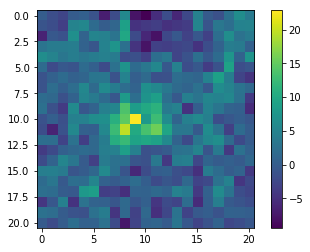

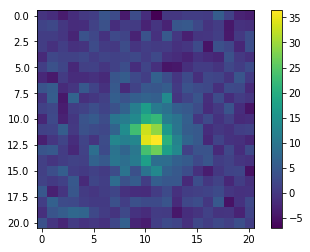

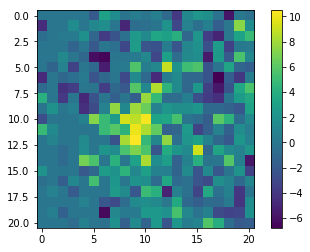

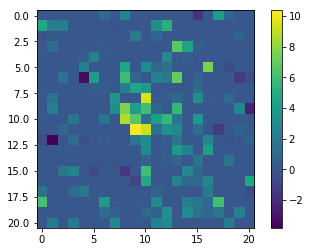

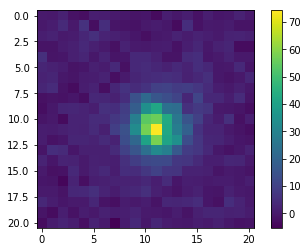

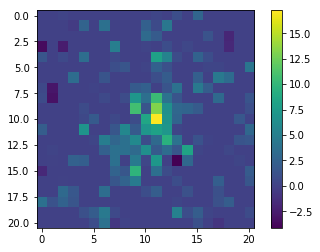

In [8]:
for stamp in good_coadd_stamps:
    plt.figure()
    plt.imshow(stamp.reshape(21,21))
    plt.colorbar()

0.12298098170684746
0.34867966092327146


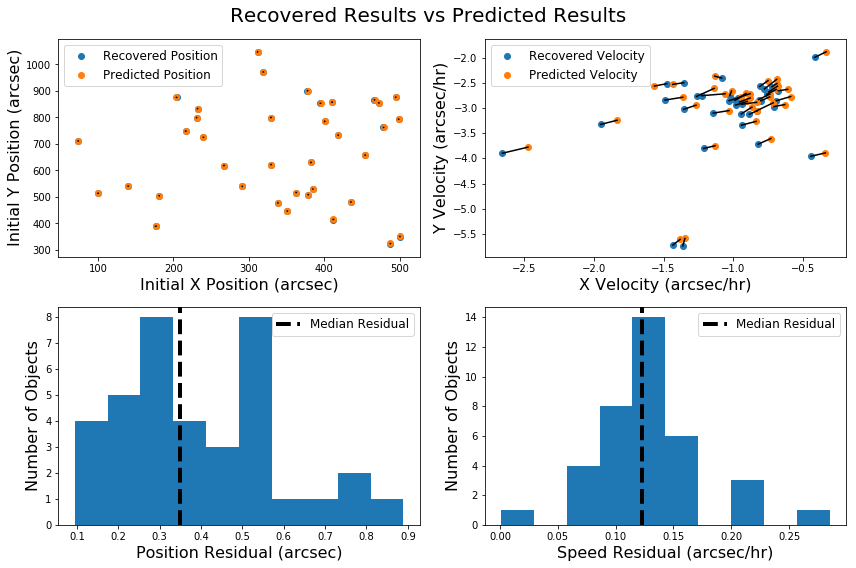

In [160]:
found_pos = []
found_vel = []
found_speed = []
pred_pos = []
pred_vel = []
pred_speed = []

for key in found_objects:
    found_x = found_results[key][0][2]
    found_y = found_results[key][0][3]
    found_vx = found_results[key][0][4]
    found_vy = found_results[key][0][5]
    found_pos.append([found_x,found_y])
    found_vel.append([found_vx,found_vy])
    found_speed.append(np.linalg.norm([found_vx,found_vy]))
    pred_pos.append(found_objects[key][5])
    pred_vel.append(found_objects[key][2])
    pred_speed.append(np.linalg.norm(found_objects[key][2]))
found_pos = np.array(found_pos)*0.26
found_vel = np.array(found_vel)*0.26/24
found_speed = np.array(found_speed)*0.26/24
pred_pos= np.array(pred_pos)*0.26
pred_vel = np.array(pred_vel)*0.26/24
pred_speed = np.array(pred_speed)*0.26/24

fig, ax = plt.subplots(ncols=2, nrows=2,figsize=[12,8])

ax[0,0].scatter(found_pos[:,0],found_pos[:,1],c='tab:blue')
ax[0,0].scatter(pred_pos[:,0],pred_pos[:,1],c='tab:orange')
ax[0,0].set_xlabel('Initial X Position (arcsec)',fontsize=16)
ax[0,0].set_ylabel('Initial Y Position (arcsec)',fontsize=16)
ax[0,0].legend(['Recovered Position','Predicted Position'],fontsize=12)
for i in range(len(found_pos)):
    ax[0,0].plot([found_pos[i,0],pred_pos[i,0]],[found_pos[i,1],pred_pos[i,1]],c='k')

ax[0,1].scatter(found_vel[:,0],found_vel[:,1],c='tab:blue')
ax[0,1].scatter(pred_vel[:,0],pred_vel[:,1],c='tab:orange')
ax[0,1].set_xlabel('X Velocity (arcsec/hr)',fontsize=16)
ax[0,1].set_ylabel('Y Velocity (arcsec/hr)',fontsize=16)
ax[0,1].legend(['Recovered Velocity','Predicted Velocity'],fontsize=12)

for i in range(len(found_vel)):
    ax[0,1].plot([found_vel[i,0],pred_vel[i,0]],[found_vel[i,1],pred_vel[i,1]],c='k')
deltaSpeed = np.linalg.norm(found_vel-pred_vel,axis=1)
print(np.median(deltaSpeed))
ax[1,1].hist(deltaSpeed)
ax[1,1].axvline(np.median(deltaSpeed),color='black',lw=4,ls='--')
ax[1,1].set_xlabel('Speed Residual (arcsec/hr)',fontsize=16)
ax[1,1].set_ylabel('Number of Objects',fontsize=16)
ax[1,1].legend(['Median Residual'],fontsize=12)

#_=plt.hist(pred_speed)
deltaPos = np.linalg.norm(found_pos-pred_pos,axis=1)
ax[1,0].hist(deltaPos) #"
print(np.median(deltaPos))
ax[1,0].axvline(np.median(deltaPos),color='black',lw=4,ls='--')
ax[1,0].set_xlabel('Position Residual (arcsec)',fontsize=16)
ax[1,0].set_ylabel('Number of Objects',fontsize=16)
ax[1,0].legend(['Median Residual'],fontsize=12)
fig.suptitle('Recovered Results vs Predicted Results', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('ResultsAnalysis.png')

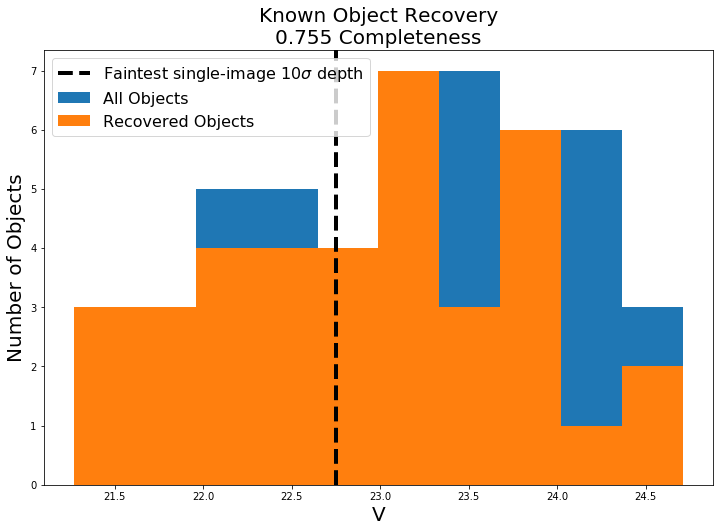

In [60]:
plt.figure(figsize=[12,8])
percent_recovered = len(found_vmag)/len(v_mag)
plt.hist(v_mag)
plt.hist(found_vmag,range=[np.min(v_mag),np.max(v_mag)])
plt.xlabel('V',fontsize=20)
plt.ylabel('Number of Objects',fontsize=20)
plt.axvline(22.75,color='black',lw=4,ls='--')
_=plt.title('Known Object Recovery\n{:.3f} Completeness'.format(percent_recovered), fontsize=20)
plt.legend([r'Faintest single-image 10$\sigma$ depth','All Objects','Recovered Objects'],fontsize=16)
#plt.savefig('object_recovery.png')

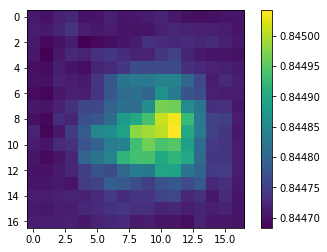

In [28]:
i = 0
j=0
size=5
heatmap = []
for j in range(22-size):
    for i in range(22-size):
        img = np.copy(stamps[0].reshape(21,21))
        img[i:i+size,j:j+size] = 0
        img /= np.sum(img)
        probs = np.concatenate(np.e**model(m_input(img)).detach().numpy())
        heatmap.append(probs[1])
plt.imshow(np.array(heatmap).reshape(22-size,22-size))
plt.colorbar()
#plt.savefig('OcclusionTesting.png')

In [16]:
foo = np.array(found_vmag)
print(len(foo[foo>22.75]))

14


(array([2., 5., 8., 6., 6., 3., 1., 2., 1., 2.]),
 array([0.30103   , 0.6767696 , 1.0525092 , 1.4282488 , 1.80398841,
        2.17972801, 2.55546761, 2.93120722, 3.30694682, 3.68268642,
        4.05842602]),
 <a list of 10 Patch objects>)

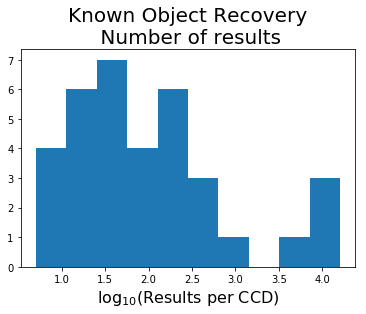

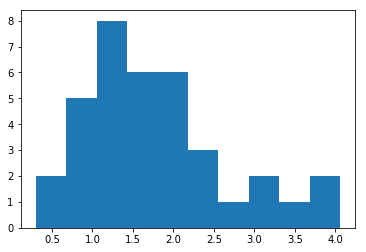

In [32]:
log_path = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/'
log_name = 'gpulh.log'
num_results = []
with open(log_path+log_name,'r') as f:
    lines = f.readlines()
    for i,line in enumerate(lines):
        if line.find('Clustering')==0:
            num_results.append(int(lines[i+1].split(' ')[1]))
plt.figure(figsize=[6,4])
plt.title('Known Object Recovery\n Number of results',fontsize=20)
plt.hist(np.log10(num_results))
plt.xlabel(r'$\log_{10}(\mathrm{Results\ per\ CCD})$', fontsize=16)

plt.figure(figsize=[6,4])
plt.hist(np.log10(num_results_neighbor))

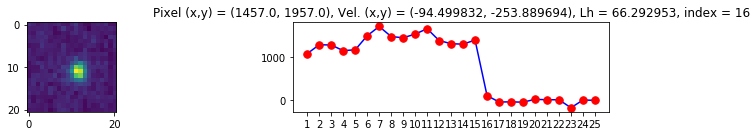

In [8]:
# Directory where output from kbmod search are located
pg_num=11
ccd_list=[29]

for ccd_num in ccd_list:
    xy_array = allObjectData[known_format.format(pg_num, ccd_num)][5]
    results_dir = '/astro/store/epyc/projects2/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
    im_dir = '/astro/store/epyc/projects2/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{0:03}/warps/{1:02d}/'.format(pg_num,ccd_num)
    suffix = 'current'

    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()
    times_list = stamper.load_times(times_filename)

    keep_idx,results,stamper,stamps,all_stamps,lc_list,psi_list,phi_list,lc_index = loadStamps(results_dir,times_list,suffix)
    #good_idx = neighbor_filter(stamps)
    if np.count_nonzero(results) != 0:
        if len(lc_list)==1:
            results=[results]
        #stamps_fig = stamper.target_stamps(results, lc_list, lc_index, stamps, 0.03, target_xy=[1458.1289606563355,1957.3085753658502],rtol=0.001)
        stamps_fig, object_found, found_idx = stamper.target_stamps(results, lc_list, lc_index, stamps, 0.03, target_xy=xy_array,atol=3,vel_tol=15)
        #stamps_fig, _, found_idx = stamper.target_stamps(results[good_idx], np.array(lc_list)[good_idx], np.array(lc_index)[good_idx], stamps[good_idx], 0.03, target_xy=xy_array,atol=3,vel_tol=15)
        #stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.03)

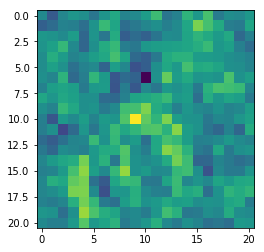

In [21]:
false_list = [element for i, element in enumerate(stamps) if i not in found_idx]
plt.imshow(false_list[19].reshape(21,21))

There are 29 results.


Text(0.5, 1.0, 'Likelihood')

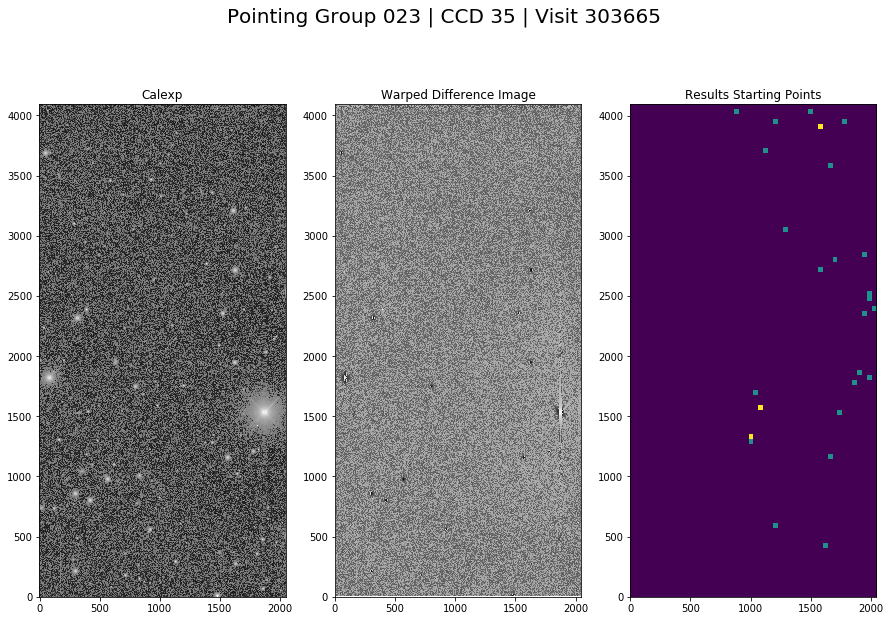

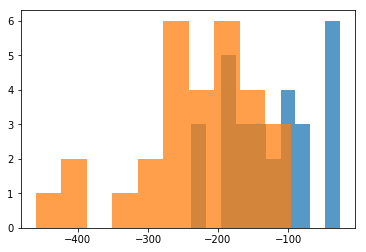

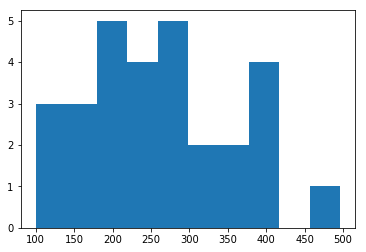

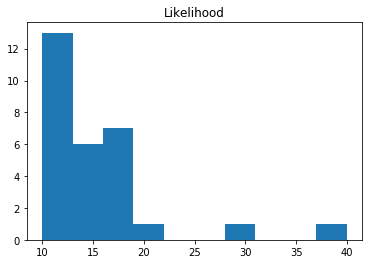

In [137]:
from astropy.io import fits
from matplotlib.patches import Circle
import numpy as np

def normalFilter(data):
    return(data)

def plotResults(pg_num, ccd_num, visit_id, results, filter_type='arcsinh', zoom=False, zoom_mask=[250,750,250,500]):
    if filter_type==None:
        apply_filter=normalFilter
    elif filter_type=='arcsinh':
        apply_filter=np.arcsinh
    elif filter_type=='log':
        apply_filter=np.log
        
    fig,[ax1,ax2,ax3]=plt.subplots(nrows=1,ncols=3,figsize=[15,10])
    warps_path = '/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/warps/{ccd:02d}/{visit:06d}.fits'
    calexp_path = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/processed_data/rerun/rerun_processed_data/{visit:07d}/calexp/calexp-{visit:07d}_{ccd:02d}.fits'
    with fits.open(calexp_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        im = ax1.imshow(apply_filter(data),origin='lower',cmap='gray')
        ax1.set_title('Calexp')
        #fig.colorbar(im, ax=ax1)

    with fits.open(warps_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        ax2.set_title('Warped Difference Image')
        im = ax2.imshow(apply_filter(data),origin='lower',cmap='gray')
        #fig.colorbar(im, ax=ax2)
    fig.suptitle('Pointing Group {:03d} | CCD {:02d} | Visit {:06d}'.format(pg_num,ccd_num,visit_id),fontsize=20)

    x = [res[2] for res in results]
    y = [res[3] for res in results]
    num_obs = [res[6] for res in results]
    data_lims = np.shape(data)
    H, xedges, yedges = np.histogram2d(x, y, range=[[0,data_lims[1]],[0,data_lims[0]]], bins=(100,50))
    _ = ax3.imshow(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
    _ = ax3.set_title('Results Starting Points')
    return(fig)
#'lh', 'flux', 'x', 'y', 'vx', 'vy', 'num_obs'
lh = [res[0] for res in results]
flux = [res[1] for res in results]
vx = np.array([res[4] for res in results])
vy = np.array([res[5] for res in results])
print('There are {} results.'.format(len(results)))
fig = plotResults(23, 35, 303665, results)
plt.figure()
plt.hist(vx,alpha=0.75)
plt.hist(vy,alpha=0.75)
plt.figure()
speed = np.sqrt(vx**2+vy**2)
plt.hist(speed)
plt.figure()
plt.hist(lh)
plt.title('Likelihood')

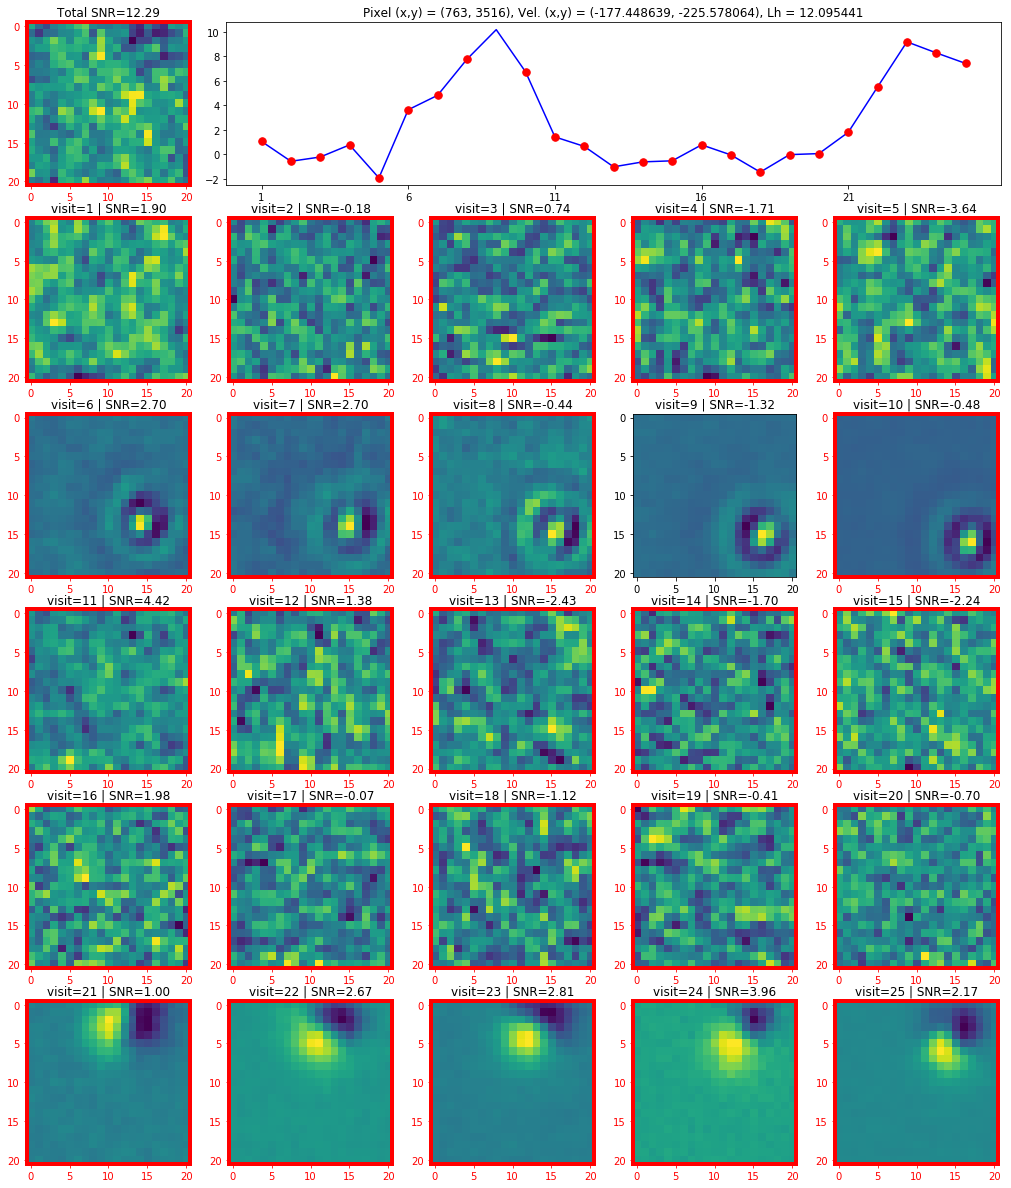

In [135]:
possible=[26]
stamper = create_stamps()
for i in possible:
    psi = psi_list[i]
    phi = phi_list[i]
    masked_phi = np.copy(phi)
    masked_phi[phi==0] = 1e9
    lh = psi/np.sqrt(masked_phi)
    fig = stamper.plot_all_stamps(results[i],lh,lc_index[i],stamps[i],all_stamps[i],sample=False)
    #fig = stamper.plot_all_stamps(results[i],lc_list[i],lc_index[i],stamps[i],all_stamps[i],sample=False)
#plt.savefig('DEEPNewObjectSample.png'.format(i))

In [86]:
from skimage import measure
def returnMoms(mom):
    return(np.array([mom[2, 0], mom[0, 2], mom[1, 1], mom[1, 0], mom[0, 1], mom[3,0], mom[0,3]]))
    
def normStamp(stamp):
    stamp = stamp.reshape(21,21)
    s = stamp - np.min(stamp)
    s /= np.sum(s)
    s = np.array(s, dtype=np.dtype('float64')).reshape(21, 21)
    return(s)

all_moms = []
all_coadd_stamps = np.load('stamp_training_set.npy')
for stamp in all_coadd_stamps:
    cppStamp = normStamp(stamp)
    cppMoms = measure.moments_central(cppStamp, center=[10,10])
    all_moms.append(returnMoms(cppMoms))
all_moms = np.array(all_moms)

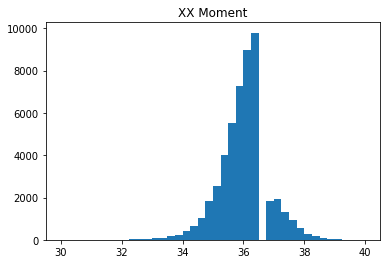

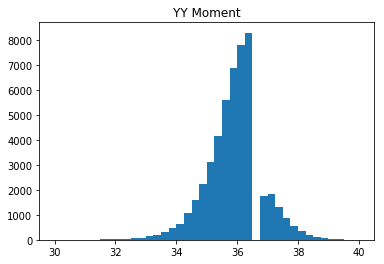

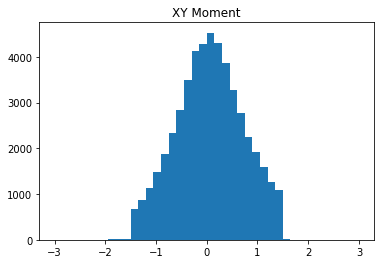

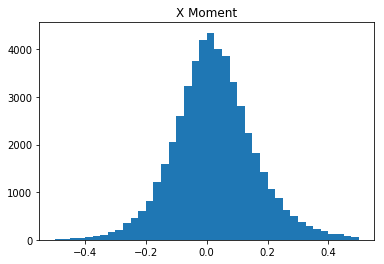

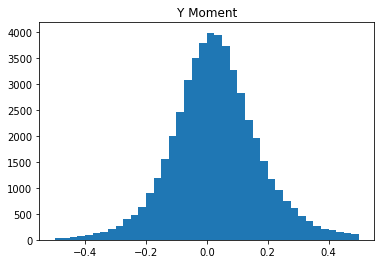

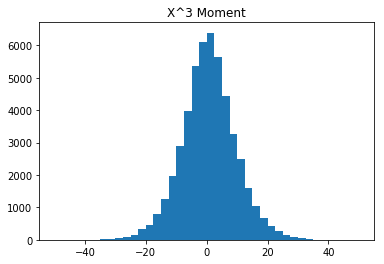

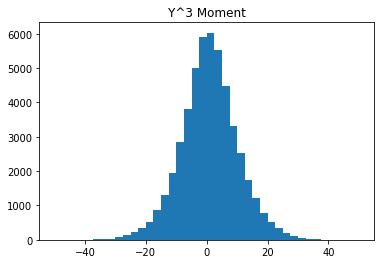

In [89]:
def plotMomHist(moms, title='', range=None, bins=None):
    plt.figure()
    plt.hist(moms,range=range,bins=bins)
    plt.title(title)

plotMomHist(all_moms[:,0], title='XX Moment', range=[30,40], bins=40)
plotMomHist(all_moms[:,1], title='YY Moment', range=[30,40], bins=40)
plotMomHist(all_moms[:,2], title='XY Moment', range=[-3,3], bins=40)
plotMomHist(all_moms[:,3], title='X Moment', range=[-0.5,0.5], bins=40)
plotMomHist(all_moms[:,4], title='Y Moment', range=[-0.5,0.5], bins=40)
plotMomHist(all_moms[:,5], title='X^3 Moment', range=[-50,50], bins=40)
plotMomHist(all_moms[:,6], title='Y^3 Moment', range=[-50,50], bins=40)


In [80]:
(1.12<36) & (12.3<36) & ( 40<1.5)

False

In [ ]:

# Directory where output from kbmod search are located
ccd_list=[43]
for ccd_num in ccd_list:
    results_dir = '/astro/store/pogo4/smotherh/DEEP/PointingGroups/A0b/results/{}/'.format(ccd_num)
    im_dir = '/astro/store/pogo4/smotherh/DEEP/PointingGroups/A0b/warps/{}/'.format(ccd_num)
    #results_dir = '/nvme/users/smotherh/DEEP/PointingGroups/A0b/results/{}/'.format(ccd_num)
    #im_dir = '/nvme/users/smotherh/DEEP/PointingGroups/A0b/warps/{}/'.format(ccd_num)
    suffix = 'sG_3'

    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()
    times_list = stamper.load_times(times_filename)

    keep_idx,results,stamper,stamps,all_stamps,lc_list,lc_index = makeStamps(results_dir,times_list,suffix)

    if np.count_nonzero(results) != 0:
        if len(lc_list)==1:
            results=[results]
        #stamps_fig = stamper.target_stamps(results, lc_list, lc_index, stamps, 0.01, target_xy=[1217.9613127459104,325.56229130147136],rtol=0.06)
        stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.0)

In [19]:
l_num = 32
tl = np.array(np.sort(times_list[l_num]) - np.min(times_list[l_num]))
print(results[l_num]['vx']*tl + results[l_num]['x'], results[l_num]['vy']*tl + results[l_num]['y'])

[1692.         1692.22275539 1692.75831903 1759.98532658] [285.         285.41229966 286.40357849 410.83456107]


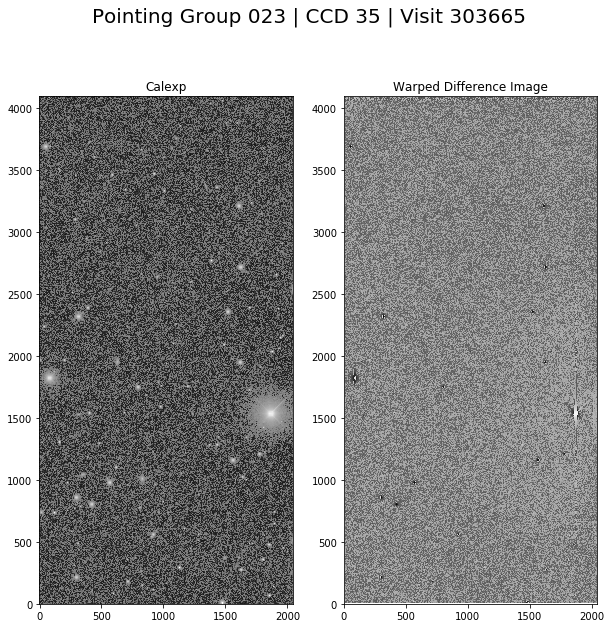

In [396]:
from astropy.io import fits
from matplotlib.patches import Circle

def normalFilter(data):
    return(data)

def plotImages(pg_num, ccd_num, visit_id, filter_type='arcsinh', zoom=False, zoom_mask=[250,750,250,500]):
    if filter_type==None:
        apply_filter=normalFilter
    elif filter_type=='arcsinh':
        apply_filter=np.arcsinh
    elif filter_type=='log':
        apply_filter=np.log
        
    fig,[ax1,ax2]=plt.subplots(nrows=1,ncols=2,figsize=[10,10])
    warps_path = '/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/warps/{ccd:02d}/{visit:06d}.fits'
    calexp_path = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/processed_data/rerun/rerun_processed_data/{visit:07d}/calexp/calexp-{visit:07d}_{ccd:02d}.fits'
    with fits.open(calexp_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        im = ax1.imshow(apply_filter(data),origin='lower',cmap='gray')
        ax1.set_title('Calexp')
        #fig.colorbar(im, ax=ax1)

    with fits.open(warps_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        ax2.set_title('Warped Difference Image')
        im = ax2.imshow(apply_filter(data),origin='lower',cmap='gray')
        #fig.colorbar(im, ax=ax2)
    fig.suptitle('Pointing Group {:03d} | CCD {:02d} | Visit {:06d}'.format(pg_num,ccd_num,visit_id),fontsize=20)
    return(fig)
fig = plotImages(23, 35, 303665, zoom=False, zoom_mask=[1100,1600,0,250])
plt.savefig('ImDiff_Example')

In [40]:
import bokeh.plotting as bkp
pg_num=29
ccd_num=54
visit_id=435146
calexp_path = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/processed_data/rerun/rerun_processed_data/{visit:07d}/calexp/calexp-{visit:07d}_{ccd:02d}.fits'
with fits.open(calexp_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
    data = np.array(hdul[1].data)
    print(np.shape(data[0]))
    fig = bkp.figure()
    fig.image([np.arcsinh(data)],0,0,1000,2000)

    bkp.show(fig)  # open a browser

(2046,)


In [304]:
numImages = 30
psi = 500*(np.random.random(numImages)-.1)
phi = 500*(np.random.random(numImages))
psi = np.append(psi,np.zeros(70))
phi = np.append(phi,np.zeros(70))
foophi = np.copy(phi)
foophi[foophi==0]=1
data = psi/np.sqrt(foophi)
idxArray = np.linspace(0,numImages-1,numImages)
idxArray = np.append(idxArray,-np.ones(70)).astype(int)
print(data)
for j in range(numImages):
    for k in range(j+1,numImages):
        if data[idxArray[j]]>data[idxArray[k]]:
            tmp = idxArray[j]
            idxArray[j] = idxArray[k]
            idxArray[k] = tmp
print(idxArray)
print(data[idxArray[0:numImages]])
np.all(np.diff(data[idxArray[0:numImages]])>0)

[ 2.93471208 -2.13035749  5.76550908  9.05131105 57.3025685  58.02967513
 -1.05574743 19.06582408 13.93544239 17.37816197 12.63468288 21.34998815
 14.84165408 13.33641222 10.45106693  4.46336451 12.97500323 34.44423899
  0.98789722  4.02978758  7.10643021 26.71809649  0.096816   11.69511721
 14.18388432  2.86608114 30.59662283  3.379311   -0.52897794 21.83497531
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          

True

In [54]:
import torch
from classify import Net
model = torch.load('./kbmod_cnn_background.pt')
model.cpu()
model.float()
model.eval()AdaptiveLogSoftmaxWithLoss

def m_input(arr):
    dat = torch.tensor([[arr]])
    dat = dat.to('cpu', torch.float)
    return dat
def predict(img):
    val = model(m_input(img)).argmax(dim=1, keepdim=True)
    return val.item()
def mispredictions(imgs, correct_answer):
    wrong = []
    for idx, img in enumerate(imgs):
        if (not predict(img) == correct_answer):
            wrong.append(idx)
    return wrong



In [55]:
true_false_list = []
for stamp in stamps:
    stamp = stamp.reshape(21,21)
    true_false_list.append(predict(stamp))

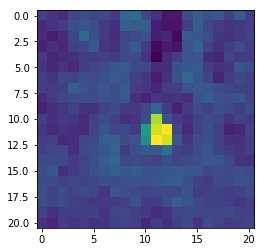

In [14]:
plt.imshow(stamps[0].reshape(21,21))

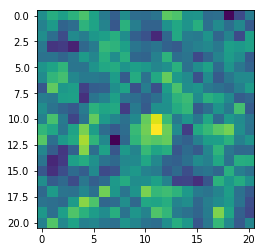

In [39]:
true_stamp = stamps[np.where(np.array(true_false_list)==1)]
plt.imshow(true_stamp.reshape(21,21))

tensor([[-4.2513e-04, -7.7632e+00]], grad_fn=<LogSoftmaxBackward>)


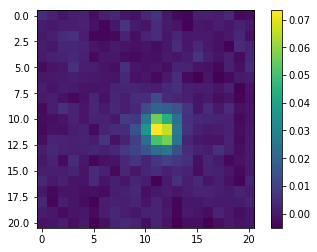

In [94]:
print(model(m_input(found_stamps[0].reshape(21,21))))
plt.imshow(found_stamps[0].reshape(21,21))
plt.colorbar()

In [79]:
filt_results[]

array([[1.49837600e+06, 2.92091200e+06, 1.94000000e+02, 4.49803494e+03],
       [2.93640100e+06, 5.60893100e+06, 2.20000000e+02, 4.94305072e+03],
       [5.68111600e+06, 1.06379600e+07, 2.43000000e+02, 5.64418184e+03],
       [1.08234700e+07, 1.99047720e+07, 2.70000000e+02, 8.11884583e+03]])

In [17]:
import pandas as pd
results_per_pixel = [1,2,4,8]
num_results_df = pd.DataFrame(columns=['res_per_pixel','f_keep_res','f_all_res','f_pass_results','f_time','nf_keep_res','nf_all_res','nf_pass_results','nf_time'])
num_results_df['res_per_pixel'] = results_per_pixel
filt_results = []
no_filt_results = []
for i, num_res in enumerate(results_per_pixel):
    log_nums = parse_num_results('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/n{}_2335.log'.format(num_res))
    filt_results.append(log_nums)
    log_nums = parse_num_results('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/nofilt_n{}_2335.log'.format(num_res))
    no_filt_results.append(log_nums)
filt_results = np.array(filt_results)
no_filt_results = np.array(no_filt_results)
num_results_df['f_keep_res'] = filt_results[:,0]
num_results_df['f_all_res'] = filt_results[:,1]
num_results_df['f_pass_res'] = filt_results[:,2]
num_results_df['f_time'] = filt_results[:,3]
num_results_df['nf_keep_res'] = no_filt_results[:,0]
num_results_df['nf_all_res'] = no_filt_results[:,1]
num_results_df['nf_pass_res'] = no_filt_results[:,2]
num_results_df['nf_time'] = no_filt_results[:,3]

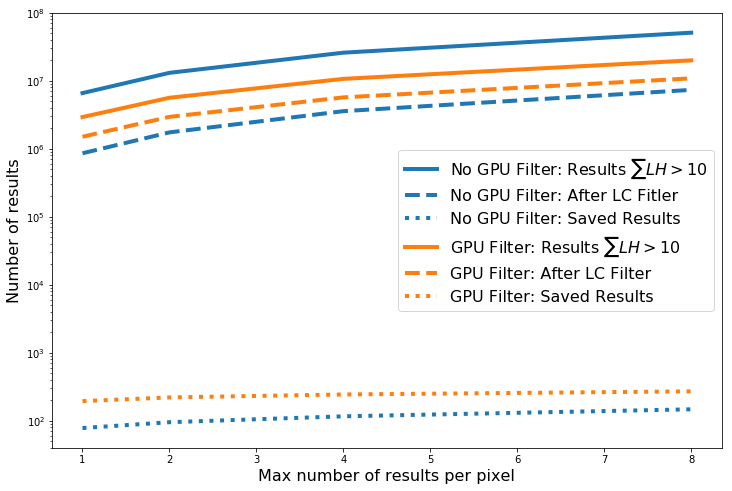

In [18]:
plt.figure(figsize=[12,8])
plt.semilogy(results_per_pixel,num_results_df['nf_all_res'],c='tab:blue',lw=4)
plt.semilogy(results_per_pixel,num_results_df['nf_keep_res'],c='tab:blue',ls='--',lw=4)
plt.semilogy(results_per_pixel,num_results_df['nf_pass_res'],c='tab:blue',ls=':',lw=4)
plt.semilogy(results_per_pixel,num_results_df['f_all_res'],c='tab:orange',lw=4)
plt.semilogy(results_per_pixel,num_results_df['f_keep_res'],c='tab:orange',ls='--',lw=4)
plt.semilogy(results_per_pixel,num_results_df['f_pass_res'],c='tab:orange',ls=':',lw=4)


plt.legend([r'No GPU Filter: Results $\sum{LH} > 10$','No GPU Filter: After LC Fitler','No GPU Filter: Saved Results',
            r'GPU Filter: Results $\sum{LH} > 10$', 'GPU Filter: After LC Filter', 'GPU Filter: Saved Results'],fontsize=16)
plt.xlabel('Max number of results per pixel', fontsize=16)
plt.ylabel('Number of results', fontsize=16)
plt.savefig('Num_Results_Filt_Nofilt.png')

In [19]:
np.mean(num_results_df['f_all_res']/num_results_df['nf_all_res'])

0.41958495495787973

In [16]:
def parse_num_results(filename):
    log_nums = np.array([])
    with open(filename) as f:
        get_next_line = False
        for line in f:
            if 'total results' in line:
                for t in line.split():
                    try:
                        log_nums = np.append(log_nums,float(t))
                    except ValueError:
                        pass
            if get_next_line:
                for t in line.split():
                    try:
                        log_nums = np.append(log_nums,float(t))
                    except ValueError:
                        pass
            if 'Clustering' in line:
                # Get all the floats in the log after Clustering
                # This will add total number of saved results and processing time taken
                get_next_line=True
    return(log_nums)